In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
import itertools
from ml_metrics import rmsle

import xgboost as xgb

from statsmodels.tsa.api import Holt

import helpers as h
from functools import partial
from collections import namedtuple

import time
import warnings

%matplotlib inline

In [2]:
train = pd.read_hdf('../input/crypto_fixed_train.h5')
test = pd.read_hdf('../input/crypto_test.h5')

In [3]:
history_lag_count = 250 #how many lagged values are used as features
pred_count = 48 #how many values is being predicted
history_lags  = ['hist_{}'.format(lag) for lag in range(1, history_lag_count + 1) ]
future  = ['future_{}'.format(lag) for lag in range(1, pred_count + 1) ] #used for validation. Real values
future_linear_preds  = ['pred_linear_{}'.format(lag) for lag in range(1, pred_count + 1) ] #simple predictions with linear model
future_preds  = ['pred_{}'.format(lag) for lag in range(1, pred_count + 1) ] #target values
log_transform_for_pred = False
train_test_ratio = 0.8

In [4]:
metadata_desc = namedtuple('features_desc', 'history_lags future future_preds')
metadata_desc.history_lags = history_lags
metadata_desc.future = future
metadata_desc.future_preds = future_preds

### Preparing data for train test and validation

In [5]:
#Timeseries are duplicated in source. To avoid overfitting i take only every even series for training
proper_indexes = train.groupby('ts').mean().sort_values(['value'])[::2].sort_index().index.values

proper_train = train[train.ts.isin(proper_indexes)]

#copy of test frame. Used for validation
proper_validation = test[test.ts.isin(proper_indexes)]
proper_validation.at[:,['datetime']] = proper_validation.datetime - pd.Timedelta(pred_count, unit='h')

F:\Python\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
basic_features_test = ['ts'] + history_lags + future_linear_preds + future


# I transform train data from:
#date             ts    value
#***
#20.12.2018 12:00 1     55.43
#20.12.2018 13:00 2     54.23
#***

# to frame with one row per time series
# ts   hist_250 *** hist_2 hist_1 pred_linear_1 pred_linear_2 *** future_1 future_2 ***
# 1    45.55    *** 55.43  54.23  53.12         52.14         *** 53.1    53.2      ***


df_ts_featurized_train = h.transform_into_horizontal_time_series(proper_train,
                                                    history_lag_count,
                                                    basic_features_test,
                                                    prediction_size = pred_count,
                                                    ignored_tail_size = pred_count,
                                                    linear_predictions_count = len(future_linear_preds))

df_ts_featurized_validation = h.transform_into_horizontal_time_series(proper_train,
                                                    history_lag_count,
                                                    basic_features_test,
                                                    prediction_size = pred_count,
                                                    linear_predictions_count = len(future_linear_preds))
assert not df_ts_featurized_train.isnull().any().any()
assert not df_ts_featurized_validation.isnull().any().any()

In [7]:
df_ts_featurized_train.head()

,ts,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,...,future_39,future_40,future_41,future_42,future_43,future_44,future_45,future_46,future_47,future_48
0,0,9.582421,9.686305,9.752343,10.242633,10.283348,10.287596,9.776010,10.187960,9.441078,...,8.975338,8.115225,7.538349,7.428168,7.476965,7.748426,6.986482,5.846849,5.617841,6.026425
1,3,167.229532,165.816093,168.874682,169.453961,168.944196,169.708843,171.493020,170.149095,170.149095,...,161.737974,164.008745,163.429466,161.691632,160.208679,160.023310,158.308646,156.825694,157.080576,157.845224
2,4,172.512550,172.327181,174.018674,178.560215,183.982260,182.105399,185.743266,190.284808,182.383452,...,149.688985,153.187826,153.095142,154.925661,156.431785,157.543999,156.640325,148.970680,147.812124,148.762140
3,6,590.195367,557.083820,554.442311,554.256942,555.971606,554.789878,556.782596,564.707123,548.394646,...,587.762399,587.855083,581.529364,582.154985,584.425756,586.094077,583.939162,583.939162,578.378090,578.748828
4,7,423.154680,422.575402,421.741241,416.272854,415.253324,416.226512,416.643592,412.634986,412.797184,...,422.575402,425.657162,427.093772,428.854778,425.193740,424.568119,418.450940,412.681329,411.499601,412.820355


In [8]:
df_ts_featurized_train[future_linear_preds].head(2)

,pred_linear_1,pred_linear_2,pred_linear_3,pred_linear_4,pred_linear_5,pred_linear_6,pred_linear_7,pred_linear_8,pred_linear_9,pred_linear_10,...,pred_linear_39,pred_linear_40,pred_linear_41,pred_linear_42,pred_linear_43,pred_linear_44,pred_linear_45,pred_linear_46,pred_linear_47,pred_linear_48
0,15.350061,15.212263,15.074464,14.936665,14.798866,14.661068,14.523269,14.385470,14.247672,14.109873,...,10.113711,9.975913,9.838114,9.700315,9.562517,9.424718,9.286919,9.149121,9.011322,8.873523
1,180.260856,180.255668,180.250479,180.245291,180.240102,180.234914,180.229726,180.224537,180.219349,180.214161,...,180.063699,180.058511,180.053322,180.048134,180.042946,180.037757,180.032569,180.027381,180.022192,180.017004


### Creating xgboost models

In [9]:
train_size = int(train_test_ratio * len(df_ts_featurized_train)) # split for train test

df_xgb_train = df_ts_featurized_train[:train_size]
df_xgb_test = df_ts_featurized_train[train_size:]
print(len(df_ts_featurized_train))
print(len(df_xgb_train))
print(len(df_xgb_test))
assert len(df_ts_featurized_train) == len(df_xgb_train)+len(df_xgb_test)

825
660
165


In [10]:
feats = history_lags + future_linear_preds
targets = future

#I build 48 models. One for every point in future
#hyperopt for those params
xgb_params = { 'max_depth': 5, 'n_estimators':  462, 'learning_rate': 0.2768203594184327, 'colsample_bytree': .7, 'subsample': 0.7, 'random_state ': 2013}
models = h.build_prediction_models(df_xgb_train, df_xgb_test, feats, targets, xgb_params, False)

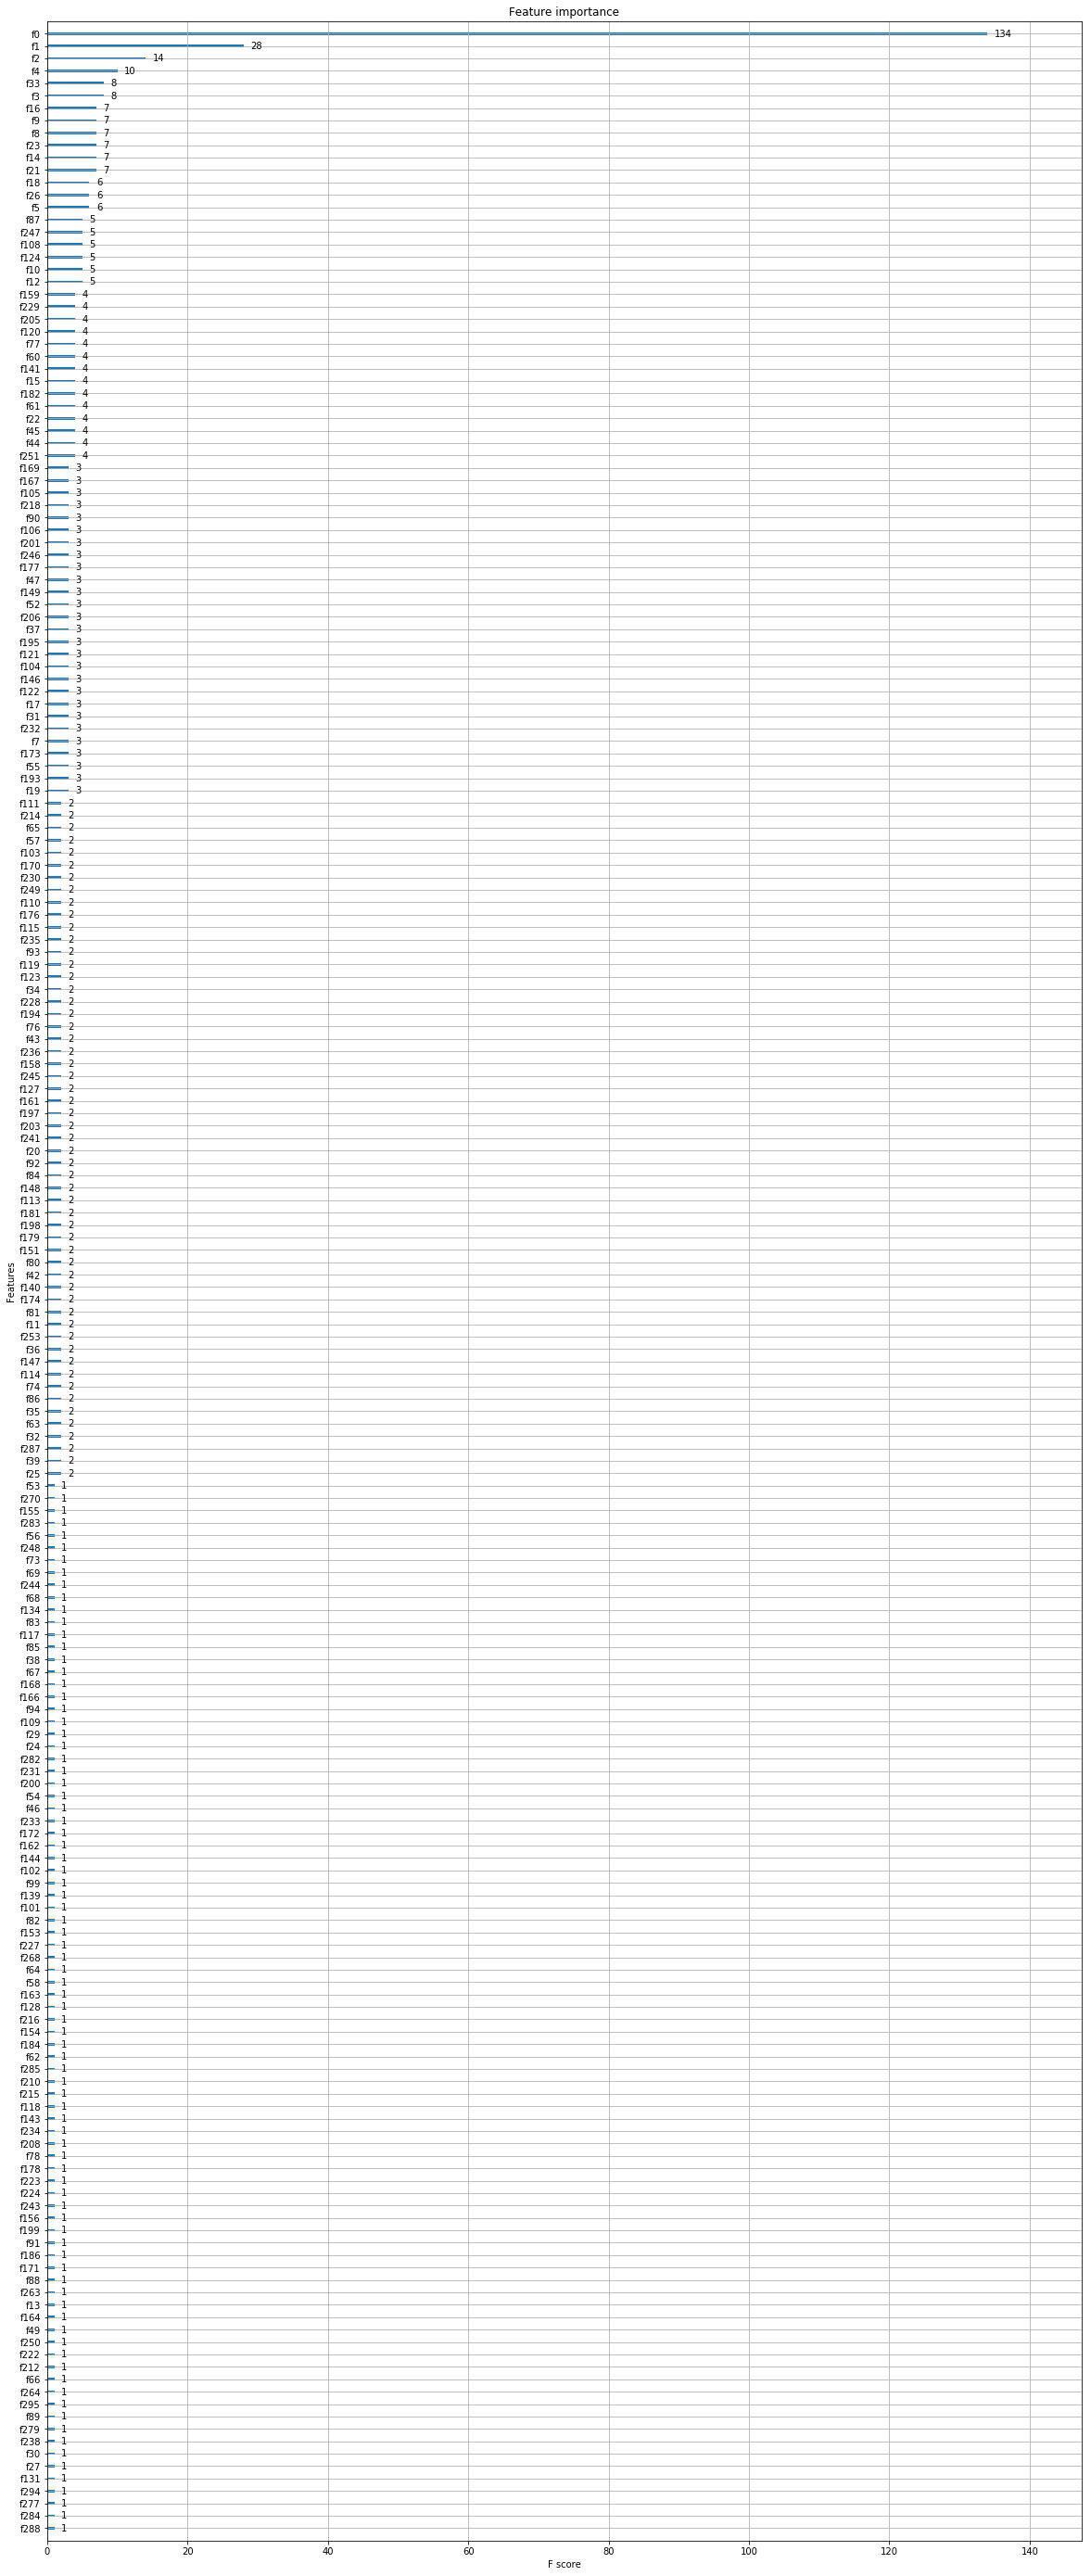

In [11]:
x=xgb.plot_importance(models[targets[0]].model)
x.figure.set_size_inches(20, 50) 

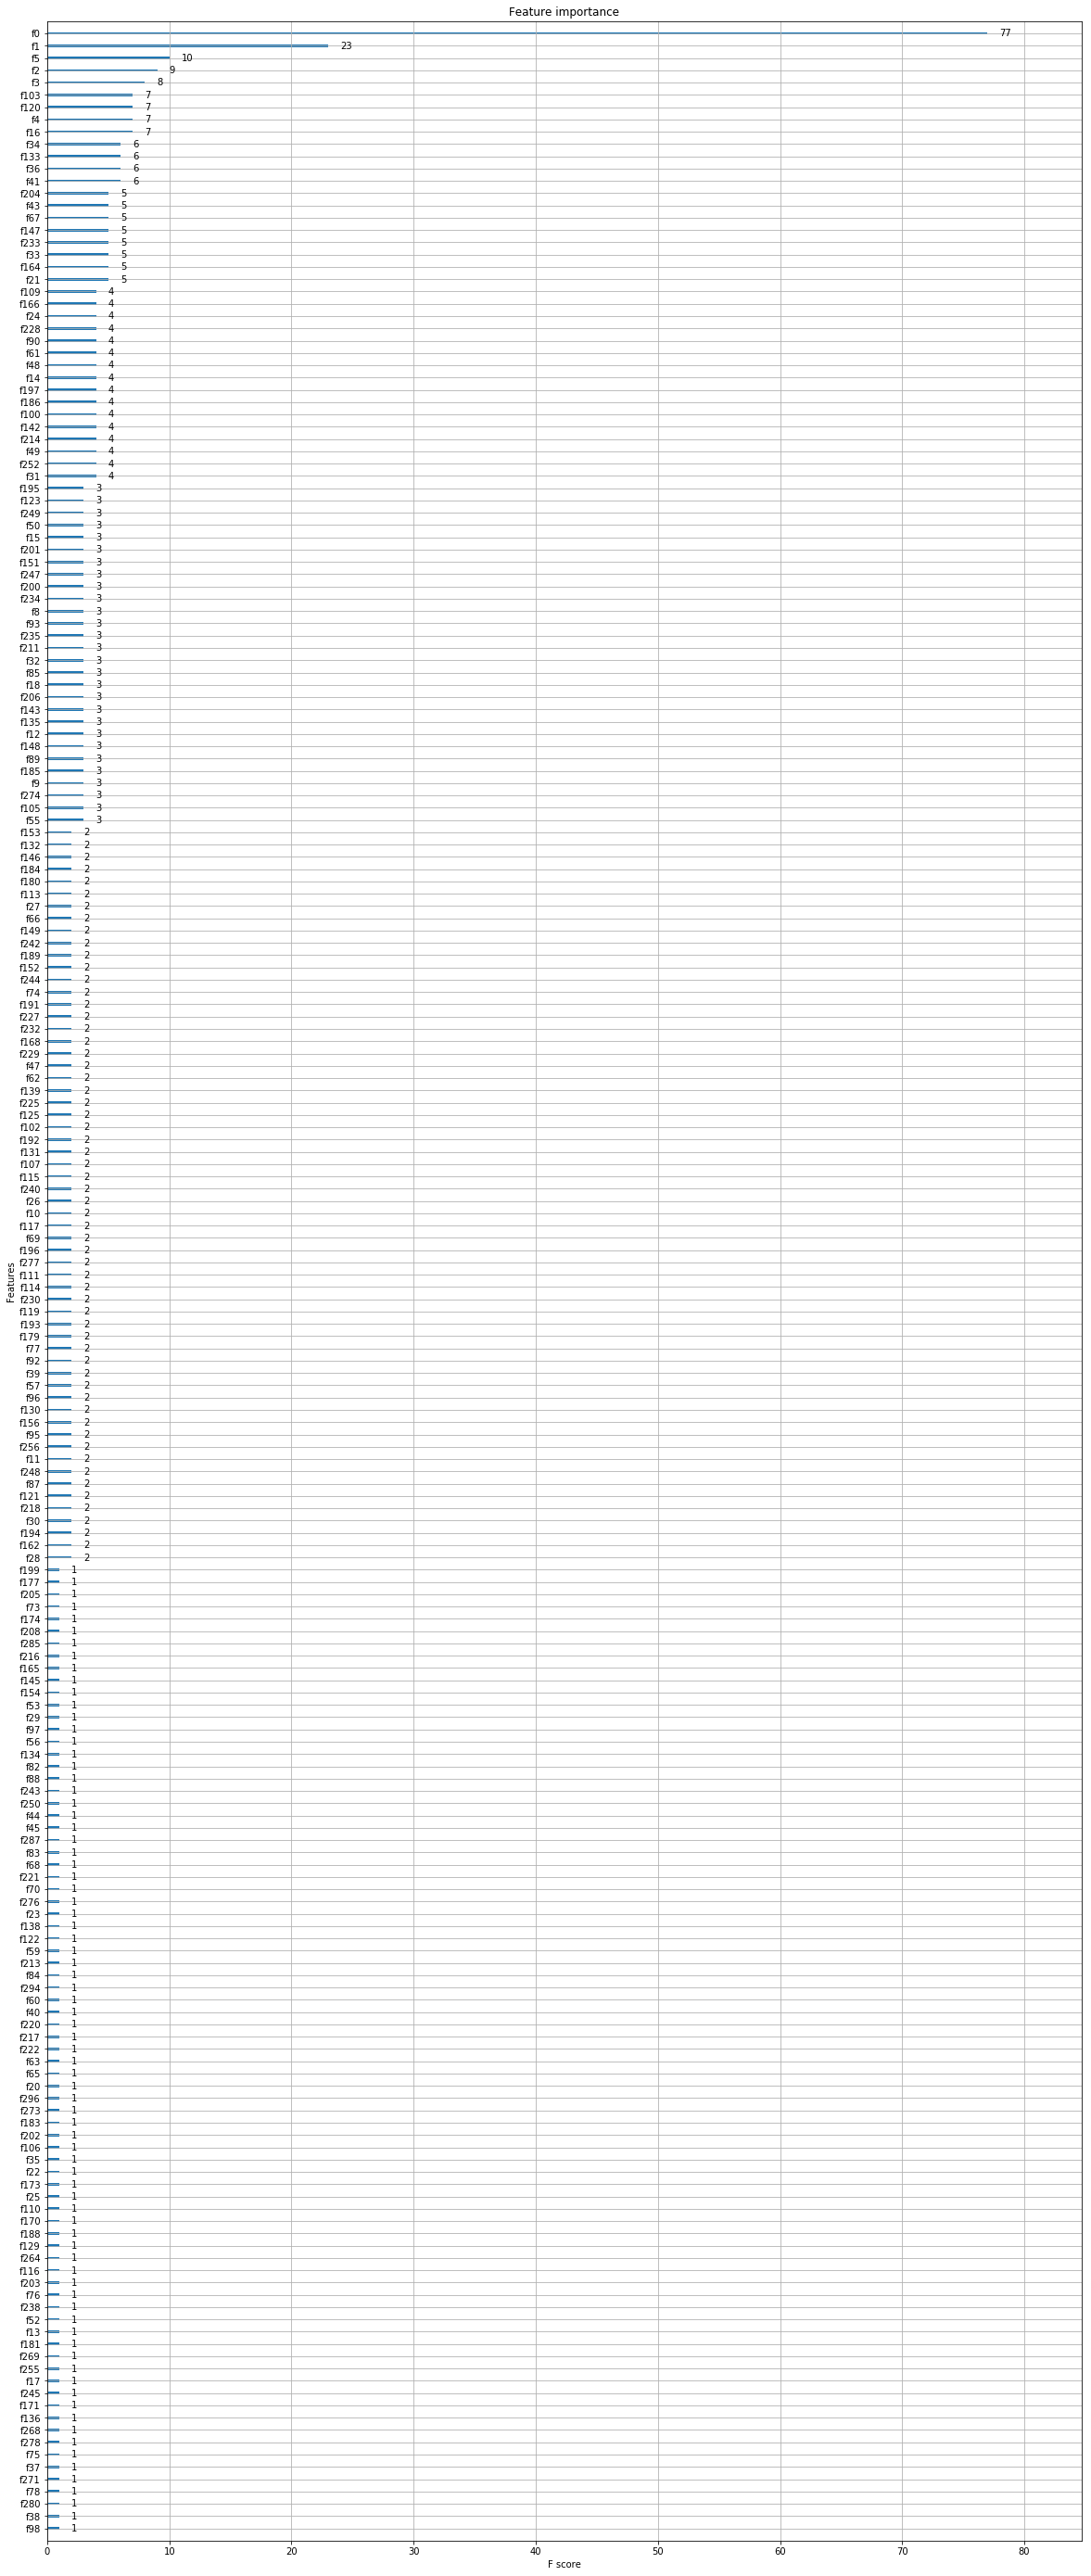

In [12]:
x=xgb.plot_importance(models[targets[47]].model)
x.figure.set_size_inches(20, 50) 

### Validation

In [13]:
for (index,target) in enumerate(targets):
    model = models[target]
    model_feats = feats    
    if log_transform_for_pred:             
        y_log_pred = model.predict(df_ts_featurized_validation[feats].values)
        y_pred = np.exp(y_log_pred) - 1
    else:
        y_pred = model.predict(df_ts_featurized_validation[model_feats].values)

    y_pred[y_pred<0]=0
    df_ts_featurized_validation['pred_{}'.format(index + 1)] = y_pred

In [14]:
h.decompose_prediction_to_vertical(df_ts_featurized_validation, proper_validation, metadata_desc, add_real_future_values=True)

G:\Kurs\cryptocurrency-competition\notebooks\helpers.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_target_vertical['real_values'] = ls_real_values
G:\Kurs\cryptocurrency-competition\notebooks\helpers.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_target_vertical['xgb_prediction'] = ls_xgb_prediction
G:\Kurs\cryptocurrency-competition\notebooks\helpers.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [15]:
for i in range(0,101,5):
    weighted_prediction = (i* proper_validation.gradient_xgb_r_8_last + (100-i)*proper_validation.dummy_last)/100
    print('msle xgb {}%   {}'.format(i, rmsle(proper_validation.real_values.values, weighted_prediction)))

msle xgb 0%   0.19067218287743257
msle xgb 5%   0.19007621999131744
msle xgb 10%   0.18955665089053905
msle xgb 15%   0.18910600742799646
msle xgb 20%   0.18871816087111282
msle xgb 25%   0.18838801040227757
msle xgb 30%   0.18811125823128239
msle xgb 35%   0.18788424377489205
msle xgb 40%   0.1877038191156261
msle xgb 45%   0.18756725393339313
msle xgb 50%   0.18747216188295243
msle xgb 55%   0.18741644284224357
msle xgb 60%   0.1873982370854017
msle xgb 65%   0.18741588853916766
msle xgb 70%   0.1874679150452075
msle xgb 75%   0.18755298408798632
msle xgb 80%   0.1876698928314859
msle xgb 85%   0.18781755158600685
msle xgb 90%   0.18799497003031848
msle xgb 95%   0.18820124566600308
msle xgb 100%   0.18843555409472731


In [16]:
xgb_weight = 70
proper_validation.value = (xgb_weight* proper_validation.gradient_xgb_r_8_last + (100-xgb_weight)*proper_validation.dummy_last)/100

F:\Python\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


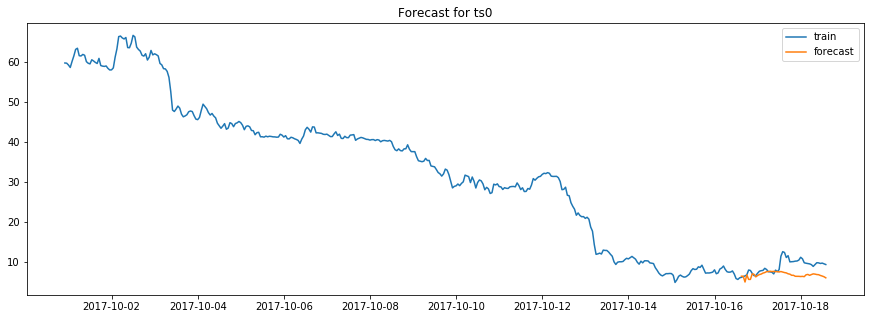

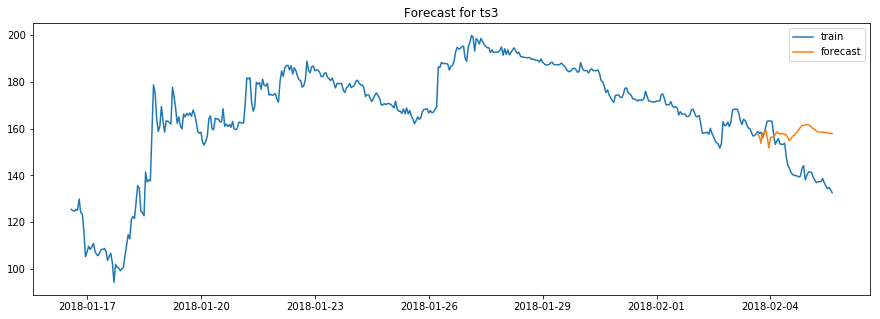

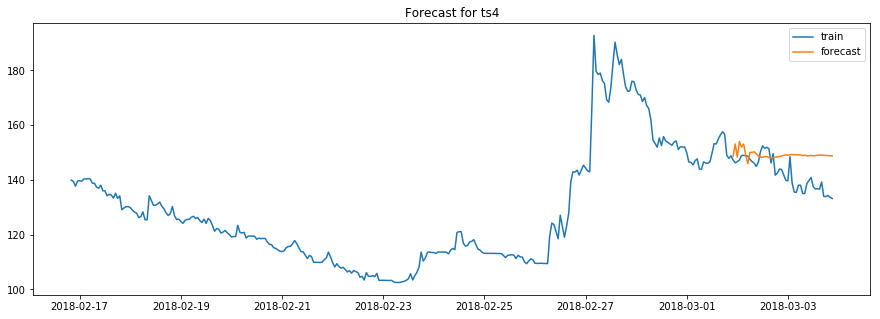

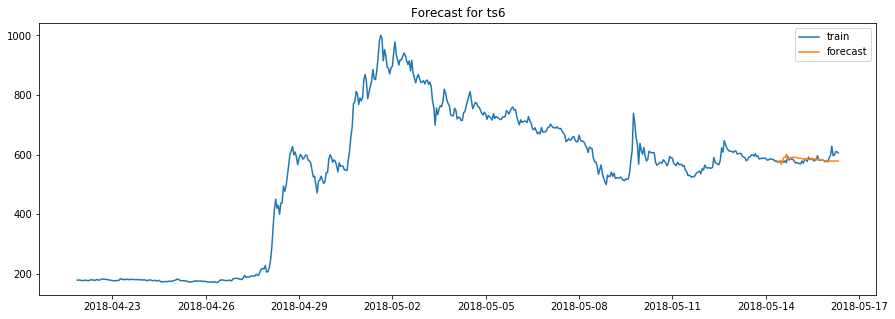

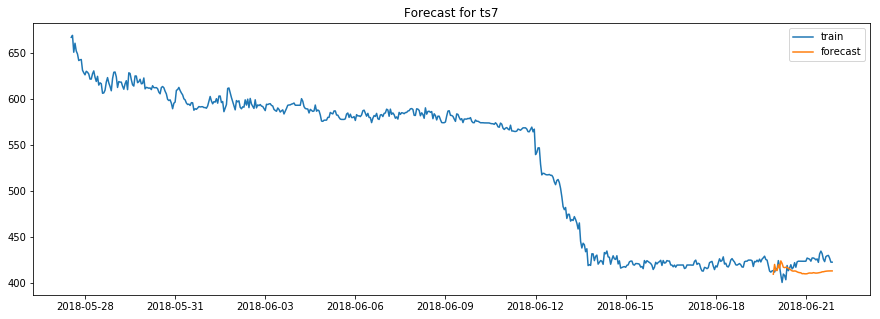

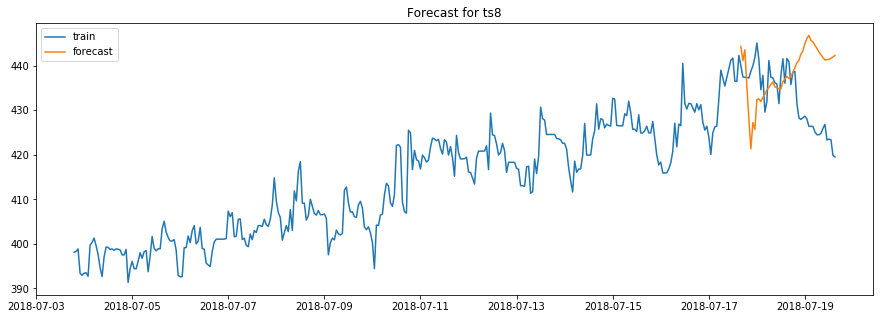

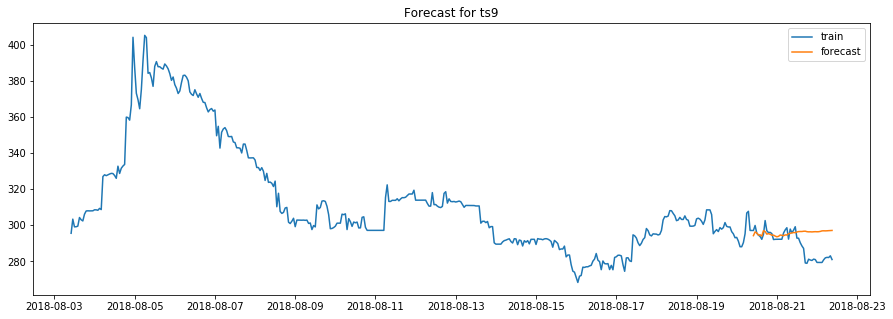

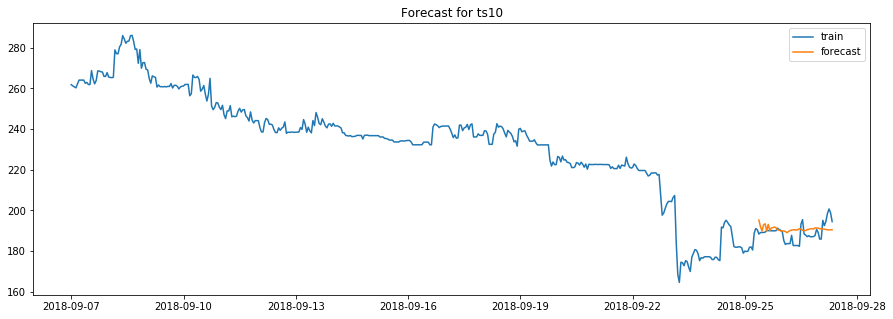

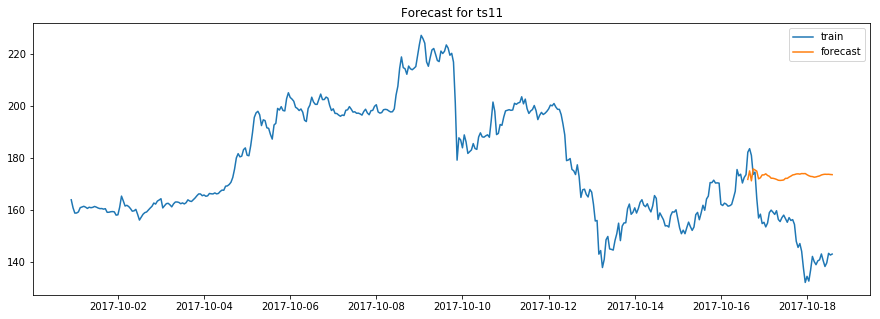

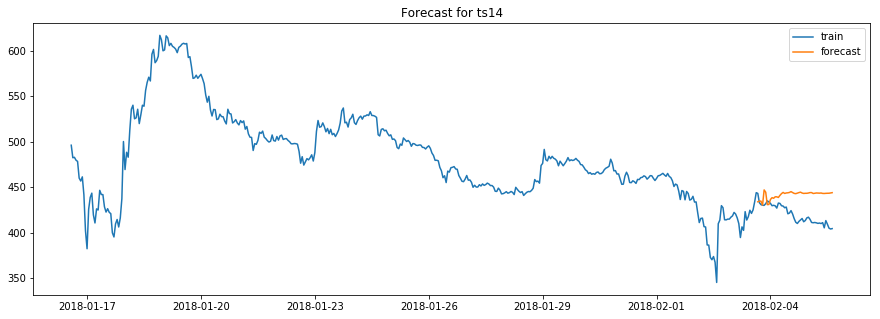

In [17]:
h.plot_validation(proper_validation.ts.unique(), train, proper_validation, validation_size = 48)

### Preparing data for final predictions

In [18]:
basic_features = ['ts'] + history_lags + future_linear_preds

df_ts_featurized_final = h.transform_into_horizontal_time_series(train,
                                                    history_lag_count,
                                                    basic_features,
                                                    prediction_size = 0,
                                                    linear_predictions_count = len(future_linear_preds))

### Making predictions

In [19]:
for (index,target) in enumerate(tqdm_notebook(targets, desc='ts loop')):
    #model_feats = feats[0:-3*len(targets)+3*index]
    model_feats = feats
    model = models[target]
    
    if log_transform_for_pred:             
        y_log_pred = model.predict(df_ts_featurized_final[feats].values)
        df_ts_predictions_final[target] = np.exp(y_log_pred) - 1
    else:
        y_pred = model.predict(df_ts_featurized_final[model_feats].values)
        
    y_pred[y_pred<0]=0
    df_ts_featurized_final['pred_{}'.format(index + 1)] = y_pred

Filling final data frame

In [20]:
h.decompose_prediction_to_vertical(df_ts_featurized_final, test, metadata_desc)

#### Tuning final response (i take weighted avarage of xgb predition and repeated last observed value)

In [21]:
xgb_weight = 60 #percents
test.value = (xgb_weight* test.gradient_xgb_r_8_last + (100-xgb_weight)*test.dummy_last)/100

#### Visual validation of results

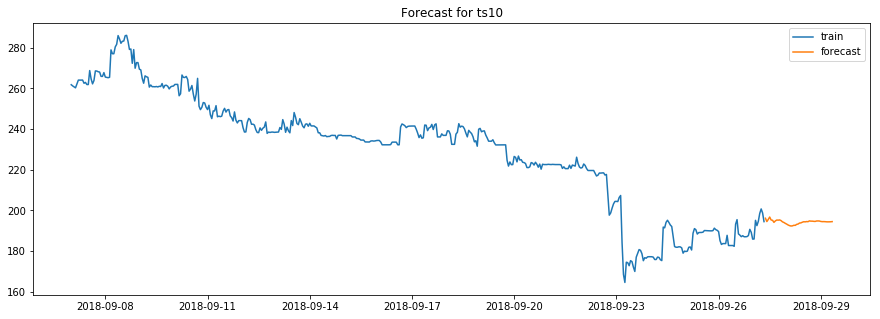

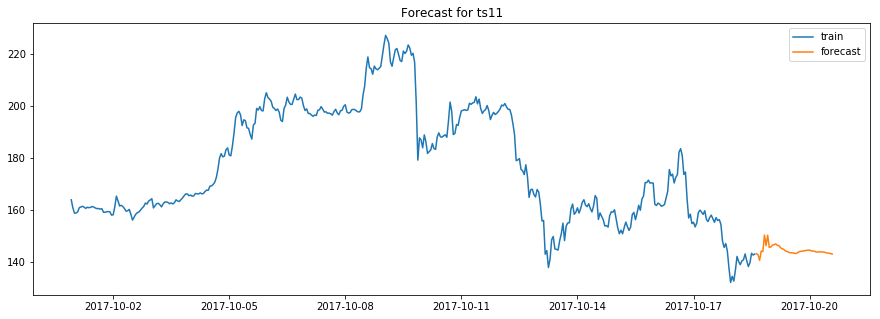

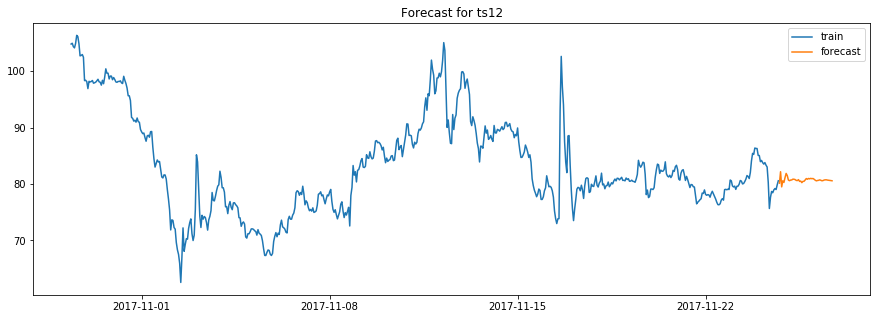

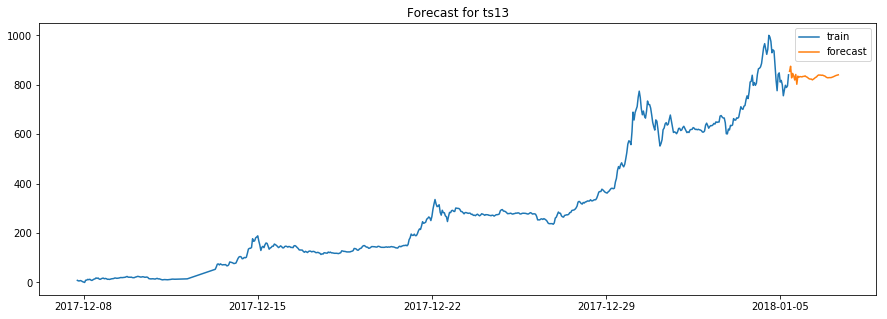

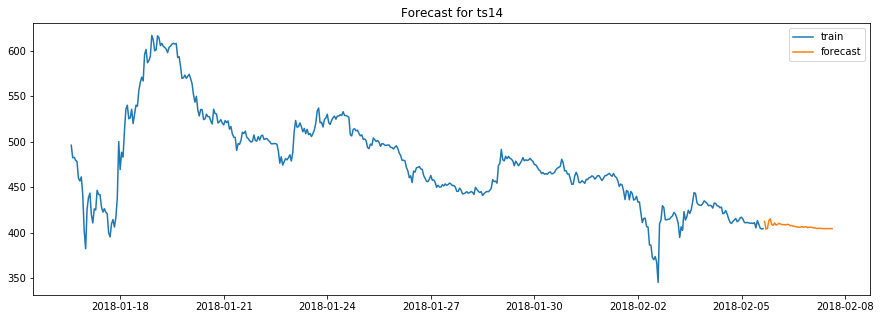

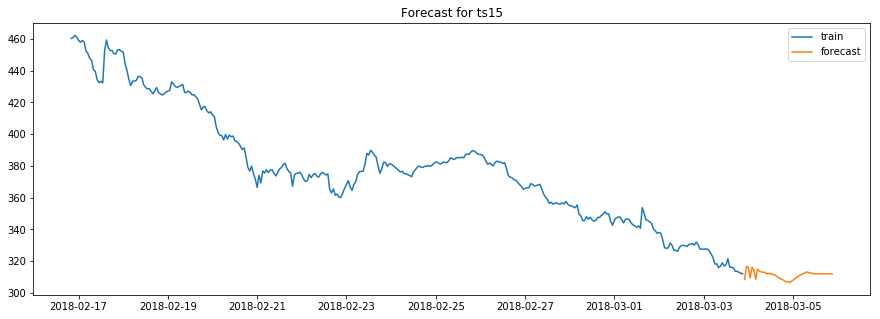

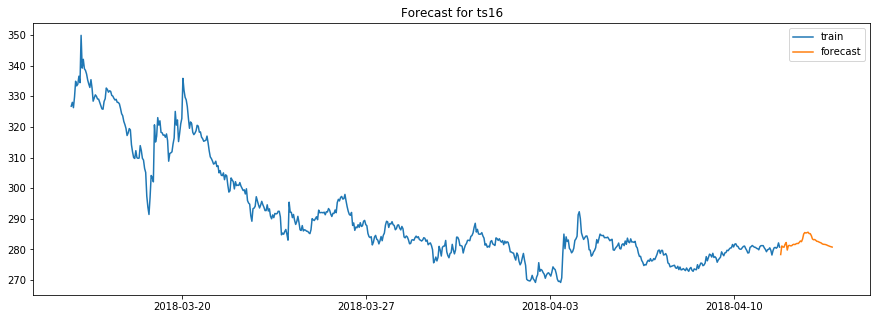

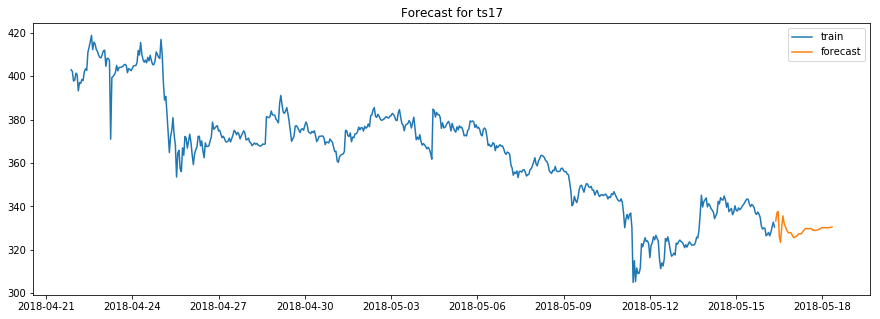

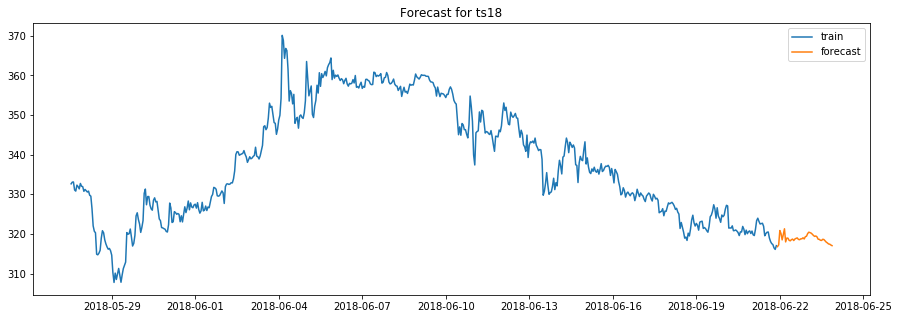

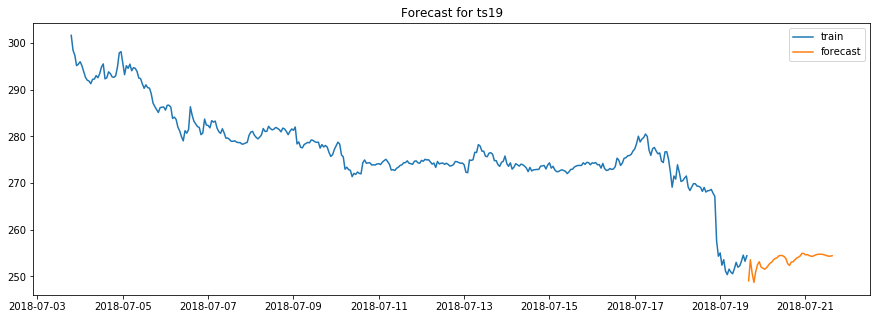

In [22]:
h.plot_series(range(10,20,1), train, test)

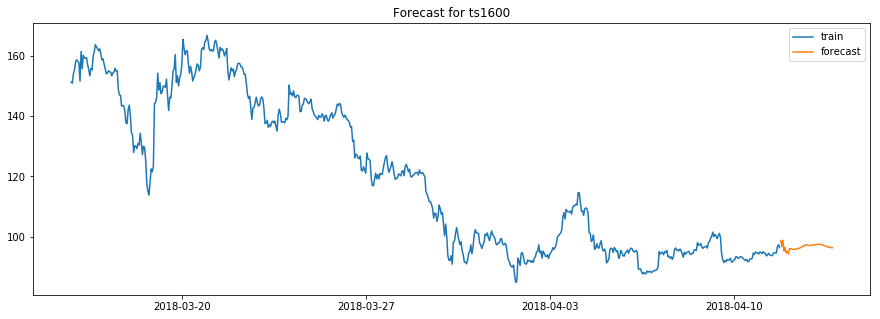

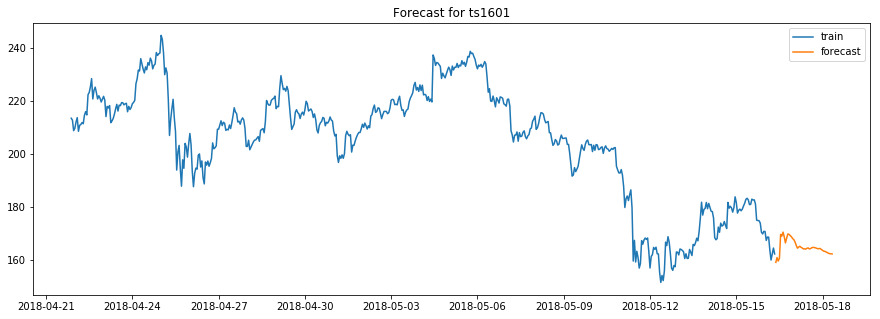

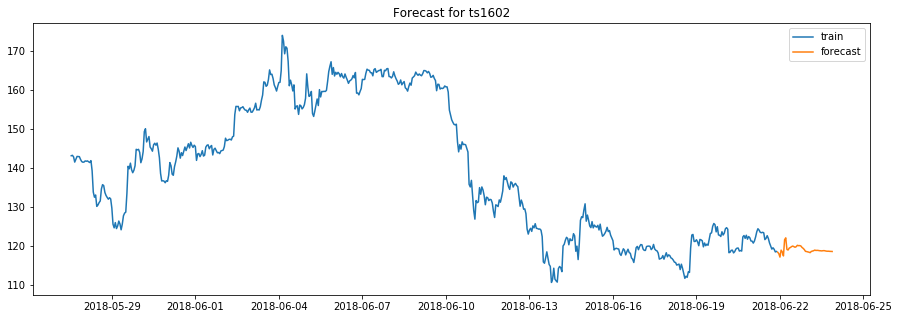

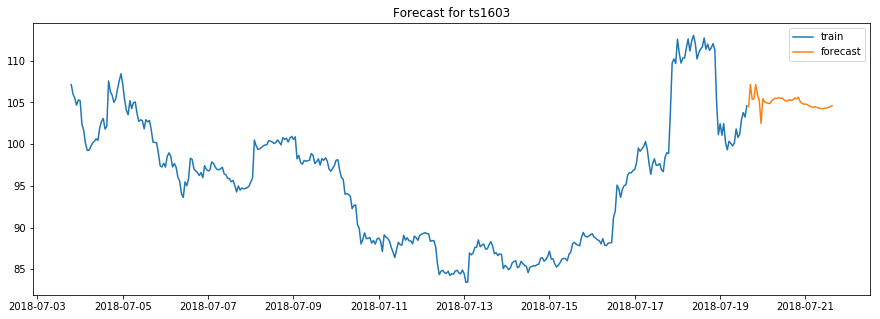

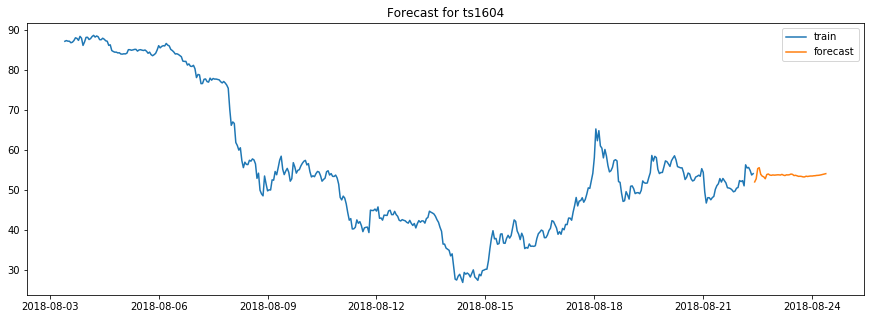

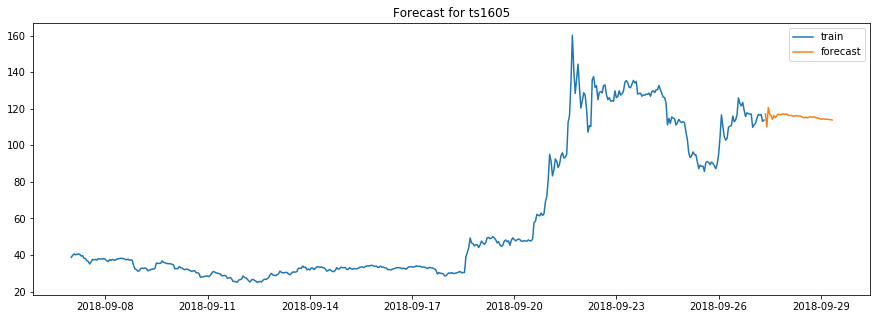

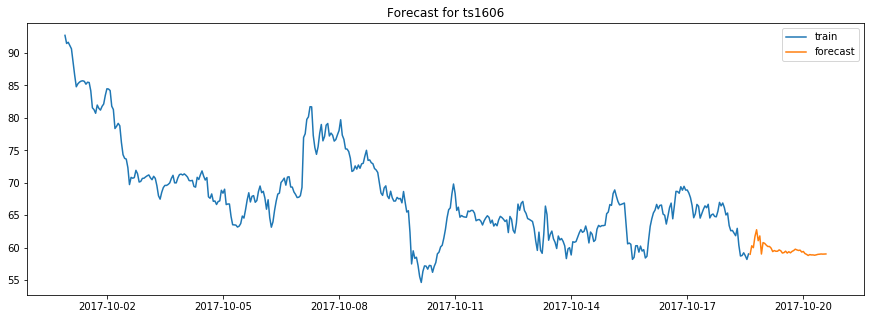

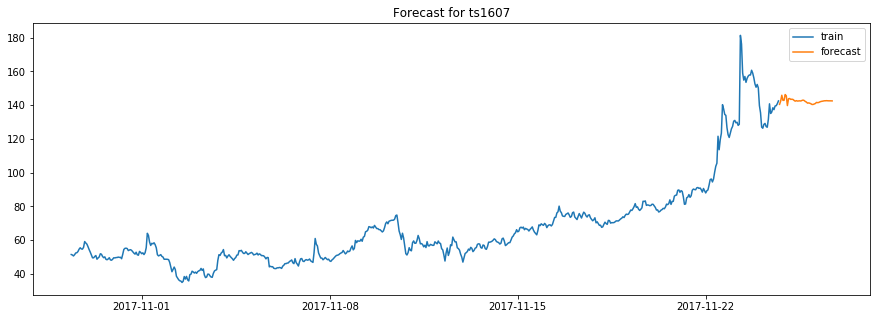

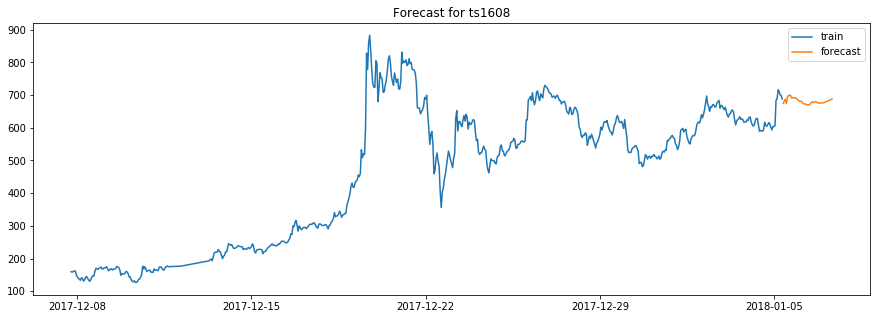

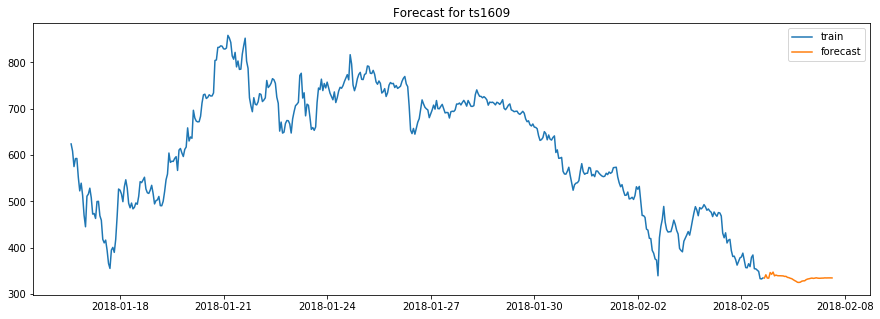

In [23]:
h.plot_series(range(1600,1610,1), train, test)

In [24]:
test.loc[test.value<=0, 'value']=0.01

In [25]:
h.validate_test(test)

#### creating filename

In [28]:
desc = 'xgboost_log_{}_lags_{}_window_{}_{}_linear_feat'.format(log_transform_for_pred, history_lag_count, 1, 10)
desc = desc+'_gradient_dummy_pred'
if xgb_weight<100:
    desc = desc+'_last_{}'.format(xgb_weight)    
desc = desc + time.strftime("%Y%m%d_%H%M%S")
desc

NameError: name 'time' is not defined

In [27]:
test[ ['id', 'value'] ].to_csv('../output/{}.csv'.format(desc), index=False) 